Errors are left as is in this notebook and resolved in the next cell. This is intentionally done to traceback why each decision was made.

## parquet paths

In [1]:
!ls ../dataset/piraeus/

107782 - The Piraeus AIS Dataset for Large-Scale Maritime Data Analytics.pdf
ais_augmented.parquet
ais_cleaned.parquet
ais_loiter.parquet
ais_loiter_pair.parquet
ais_static
chronos_predictions
geodata
models
noaa_weather
parquet
parquet_geohash
processed
sar
unipi_ais_dynamic_2017
unipi_ais_dynamic_2018
unipi_ais_dynamic_2019
unipi_ais_dynamic_synopses


In [1]:
!ls "../dataset/piraeus/parquet/unipi_ais_dynamic_2017"

unipi_ais_dynamic_aug2017.parquet
unipi_ais_dynamic_dec2017.parquet
unipi_ais_dynamic_jul2017.parquet
unipi_ais_dynamic_jun2017.parquet
unipi_ais_dynamic_may2017.parquet
unipi_ais_dynamic_nov2017.parquet
unipi_ais_dynamic_oct2017.parquet
unipi_ais_dynamic_sep2017.parquet


In [2]:
!ls ../dataset/piraeus/unipi_ais_dynamic_2017

README.md
unipi_ais_dynamic_aug2017.csv
unipi_ais_dynamic_dec2017.csv
unipi_ais_dynamic_jul2017.csv
unipi_ais_dynamic_jun2017.csv
unipi_ais_dynamic_may2017.csv
unipi_ais_dynamic_nov2017.csv
unipi_ais_dynamic_oct2017.csv
unipi_ais_dynamic_sep2017.csv


In [3]:
!ls ../dataset/piraeus/unipi_ais_dynamic_2018

README.md
unipi_ais_dynamic_apr2018.csv
unipi_ais_dynamic_aug2018.csv
unipi_ais_dynamic_dec2018.csv
unipi_ais_dynamic_feb2018.csv
unipi_ais_dynamic_jan2018.csv
unipi_ais_dynamic_jul2018.csv
unipi_ais_dynamic_jun2018.csv
unipi_ais_dynamic_mar2018.csv
unipi_ais_dynamic_may2018.csv
unipi_ais_dynamic_nov2018.csv
unipi_ais_dynamic_oct2018.csv
unipi_ais_dynamic_sep2018.csv


In [4]:
!ls ../dataset/piraeus/unipi_ais_dynamic_2019

README.md
unipi_ais_dynamic_apr2019.csv
unipi_ais_dynamic_aug2019.csv
unipi_ais_dynamic_dec2019.csv
unipi_ais_dynamic_feb2019.csv
unipi_ais_dynamic_jan2019.csv
unipi_ais_dynamic_jul2019.csv
unipi_ais_dynamic_jun2019.csv
unipi_ais_dynamic_mar2019.csv
unipi_ais_dynamic_may2019.csv
unipi_ais_dynamic_nov2019.csv
unipi_ais_dynamic_oct2019.csv
unipi_ais_dynamic_sep2019.csv


In [5]:
import pandas, pyarrow
print(pandas.__version__)
print(pyarrow.__version__)

2.3.3
23.0.0


In [6]:
from tqdm import tqdm

In [2]:
import pyarrow.parquet as pq

pq_file = pq.ParquetFile("unipi_ais_dynamic_may2017.parquet")

# Suppose row groups are ~500k rows each
row_group_index = 6  # 6*500k = 3Mth row
table = pq_file.read_row_group(row_group_index)

df_chunk = table.to_pandas()  # Only this row group in memory
row = df_chunk.iloc[0]  # Approx 3Mth row
print(row)


t                                                1494345047000
vessel_id    b0b2bd45bbb8911fbea20744b0e8b98bbb0e76f6c3af37...
lat                                                  37.929298
lon                                                  23.682772
heading                                                   30.0
speed                                                      0.0
course                                                   170.0
Name: 0, dtype: object


In [ ]:
pq_file.index.get_level_values(0).unique().tolist()

## Random Access

In [8]:
import platform; print(platform.architecture()); import sys; print(sys.version)

('64bit', 'WindowsPE')
3.10.19 | packaged by conda-forge | (main, Jan 26 2026, 23:39:36) [MSC v.1944 64 bit (AMD64)]


## Bounds

In [9]:
import pandas as pd

# Adjust to your file path
file = "../dataset/piraeus/unipi_ais_dynamic_2017/unipi_ais_dynamic_may2017.csv"

# Chunked read in case of large files
chunksize = 1_000_000
min_lat, max_lat = float('inf'), float('-inf')
min_lon, max_lon = float('inf'), float('-inf')

for chunk in pd.read_csv(file, usecols=['lat', 'lon'], chunksize=chunksize):
    min_lat = min(min_lat, chunk['lat'].min())
    max_lat = max(max_lat, chunk['lat'].max())
    min_lon = min(min_lon, chunk['lon'].min())
    max_lon = max(max_lon, chunk['lon'].max())

print("Bounds:")
print("Latitude:", min_lat, "-", max_lat)
print("Longitude:", min_lon, "-", max_lon)


Bounds:
Latitude: 37.45947 - 38.03808166666671
Longitude: 23.0350833333333 - 23.8806466666667


# Train

In [1]:
pip install -q autogluon.timeseries 

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.25.0 requires botocore<1.40.50,>=1.40.46, but you have botocore 1.42.44 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 20.0.0 which is incompatible.


In [2]:
!pip install pyarrow==21.0.0 botocore==1.40.49 --upgrade

  Using cached pyarrow-21.0.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
Using cached pyarrow-21.0.0-cp312-cp312-win_amd64.whl (26.2 MB)
   ---------------------------------------- 0.0/14.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/14.1 MB 2.6 MB/s eta 0:00:06
    --------------------------------------- 0.3/14.1 MB 4.2 MB/s eta 0:00:04
   - -------------------------------------- 0.6/14.1 MB 4.5 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/14.1 MB 4.3 MB/s eta 0:00:04
   -- ------------------------------------- 0.9/14.1 MB 3.9 MB/s eta 0:00:04
   -- ------------------------------------- 0.9/14.1 MB 3.9 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/14.1 MB 3.5 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/14.1 MB 3.5 MB/s eta 0:00:04
   -- ------------------------------------- 1.0/14.1 MB 3.5 MB/s eta 0:00:04
   --- ------------------------------------ 1.2/14.1 MB 2.7 MB/s eta 0:00:05
   ---- --------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-common 1.5.0 requires pyarrow<21.0.0,>=7.0.0, but you have pyarrow 21.0.0 which is incompatible.
boto3 1.42.44 requires botocore<1.43.0,>=1.42.44, but you have botocore 1.40.49 which is incompatible.


In [3]:
pip install autogluon.timeseries --upgrade

  Using cached pyarrow-20.0.0-cp312-cp312-win_amd64.whl.metadata (3.4 kB)
  Using cached botocore-1.42.44-py3-none-any.whl.metadata (5.9 kB)
Using cached pyarrow-20.0.0-cp312-cp312-win_amd64.whl (25.7 MB)
Using cached botocore-1.42.44-py3-none-any.whl (14.6 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 21.0.0
    Uninstalling pyarrow-21.0.0:
      Successfully uninstalled pyarrow-21.0.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.40.49
    Uninstalling botocore-1.40.49:
      Successfully uninstalled botocore-1.40.49
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.25.0 requires botocore<1.40.50,>=1.40.46, but you have botocore 1.42.44 which is incompatible.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 20.0.0 which is incompatible.


In [6]:
ls "../dataset/piraeus/unipi_ais_dynamic_2017"

 Volume in drive C is Windows
 Volume Serial Number is 22B1-CD8D

 Directory of c:\Users\BBBS-AI-01\d\anomaly\dataset\piraeus\unipi_ais_dynamic_2017

31/12/2025  02:53 pm    <DIR>          .
09/02/2026  05:49 pm    <DIR>          ..
31/12/2025  02:52 pm             1,831 README.md
31/12/2025  02:52 pm       982,705,862 unipi_ais_dynamic_aug2017.csv
31/12/2025  02:52 pm       734,582,968 unipi_ais_dynamic_dec2017.csv
31/12/2025  02:52 pm     1,022,394,184 unipi_ais_dynamic_jul2017.csv
31/12/2025  02:53 pm       993,088,856 unipi_ais_dynamic_jun2017.csv
31/12/2025  02:53 pm       527,700,689 unipi_ais_dynamic_may2017.csv
31/12/2025  02:53 pm       688,654,355 unipi_ais_dynamic_nov2017.csv
31/12/2025  02:53 pm       527,318,392 unipi_ais_dynamic_oct2017.csv
31/12/2025  02:53 pm       934,818,984 unipi_ais_dynamic_sep2017.csv
               9 File(s)  6,411,266,121 bytes
               2 Dir(s)  91,840,081,920 bytes free


In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from pathlib import Path

# Load all 2017 monthly parquet files
parquet_dir = "../dataset/piraeus/parquet/unipi_ais_dynamic_2017"
all_files = sorted(Path(parquet_dir).glob("*.parquet"))
df_list = [pd.read_parquet(f) for f in all_files]
df = pd.concat(df_list).sort_values(["vessel_id", "t"])

# Keep only id, timestamp, and targets
df = df[['vessel_id', 't', 'lat', 'lon']]

# Convert to TimeSeriesDataFrame
ts_df = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column='vessel_id',
    timestamp_column='t',
)

# Train Chronos-2 predictor
predictor = TimeSeriesPredictor(prediction_length=5).fit(
    ts_df,
    presets="chronos2",
)


We need Geohash as a single varaible target, as lat and lon are 2 varaibles.

In [6]:
pip install geohash2

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for geohash2: filename=geohash2-1.1-py3-none-any.whl size=15556 sha256=9791ce2f1e5a1477d13d0833d814cf1139774f00b611ad47af57278a7df1b88f
  Stored in directory: c:\users\bbbs-ai-01\appdata\local\pip\cache\wheels\00\d5\b6\3fbe4088f7912982f596eaddfd593d16096468a2f13e470ae7
Successfully built geohash2
Note: you may need to restart the kernel to use updated packages.


In [9]:
!ls ../dataset/piraeus/parquet

unipi_ais_dynamic_2017
unipi_ais_dynamic_2018
unipi_ais_dynamic_2019
unipi_ais_dynamic_synopses


In [10]:
import pandas as pd
from pathlib import Path
import geohash2  # pip install geohash2

# Input/output folders
INPUT_DIR = Path("../dataset/piraeus/parquet/unipi_ais_dynamic_2017")
OUTPUT_DIR = Path("../dataset/piraeus/parquet_geohash")
OUTPUT_DIR.mkdir(exist_ok=True)

def add_geohash(df: pd.DataFrame, precision: int = 7) -> pd.DataFrame:
    """
    Encode latitude and longitude columns as a geohash.
    """
    df = df.copy()
    df['geohash'] = df.apply(lambda row: geohash2.encode(row['lat'], row['lon'], precision=precision), axis=1)
    df['geohash_int'] = df['geohash'].apply(lambda x: int.from_bytes(x.encode('utf-8'), 'big'))
    return df

# Process each parquet file
for file in INPUT_DIR.glob("*.parquet"):
    df = pd.read_parquet(file)
    df = add_geohash(df)
    output_path = OUTPUT_DIR / file.name
    df.to_parquet(output_path, index=False)
    print(f"Processed and saved: {output_path}")


Processed and saved: ..\dataset\piraeus\parquet_geohash\unipi_ais_dynamic_aug2017.parquet
Processed and saved: ..\dataset\piraeus\parquet_geohash\unipi_ais_dynamic_dec2017.parquet
Processed and saved: ..\dataset\piraeus\parquet_geohash\unipi_ais_dynamic_jul2017.parquet
Processed and saved: ..\dataset\piraeus\parquet_geohash\unipi_ais_dynamic_jun2017.parquet
Processed and saved: ..\dataset\piraeus\parquet_geohash\unipi_ais_dynamic_may2017.parquet
Processed and saved: ..\dataset\piraeus\parquet_geohash\unipi_ais_dynamic_nov2017.parquet
Processed and saved: ..\dataset\piraeus\parquet_geohash\unipi_ais_dynamic_oct2017.parquet
Processed and saved: ..\dataset\piraeus\parquet_geohash\unipi_ais_dynamic_sep2017.parquet


In [15]:
!ls ../dataset/piraeus/parquet_geohash/

unipi_ais_dynamic_aug2017.parquet
unipi_ais_dynamic_dec2017.parquet
unipi_ais_dynamic_jul2017.parquet
unipi_ais_dynamic_jun2017.parquet
unipi_ais_dynamic_may2017.parquet
unipi_ais_dynamic_nov2017.parquet
unipi_ais_dynamic_oct2017.parquet
unipi_ais_dynamic_sep2017.parquet


In [16]:
import pandas as pd
from pathlib import Path
import geohash2  # pip install geohash2
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

# -------------------------------
# 1. Paths
# -------------------------------
PARQUET_DIR = Path("../dataset/piraeus/parquet_geohash/")
OUTPUT_DIR = Path("../dataset/piraeus/chronos_predictions")
OUTPUT_DIR.mkdir(exist_ok=True)

# -------------------------------
# 2. Load all 2017 Parquet files
# -------------------------------
all_files = sorted(PARQUET_DIR.glob("*.parquet"))
df_list = [pd.read_parquet(f) for f in all_files]
df = pd.concat(df_list).sort_values(["vessel_id", "t"])

# -------------------------------
# 3. Encode geohash as categorical target
# -------------------------------
df['geohash'] = df.apply(lambda row: geohash2.encode(row['lat'], row['lon'], precision=7), axis=1)

# Keep only vessel_id, timestamp, and target
ts_df = df[['vessel_id', 't', 'geohash']]

# -------------------------------
# 4. Convert to TimeSeriesDataFrame
# -------------------------------
ts_df = TimeSeriesDataFrame.from_data_frame(
    ts_df,
    id_column='vessel_id',
    timestamp_column='t',
)

# -------------------------------
# 5. Train Chronos-2 predictor (classification)
# -------------------------------
predictor = TimeSeriesPredictor(
    prediction_length=5,
    problem_type='classification',  # categorical geohash
    eval_metric='accuracy',
).fit(
    ts_df,
    presets="chronos2",
)

# -------------------------------
# 6. Make predictions
# -------------------------------
predictions = predictor.predict(ts_df)

# Decode predicted geohash back to lat/lon
def decode_geohash_series(gh_series):
    lat_lon = gh_series.apply(lambda gh: geohash2.decode(gh) if gh is not None else (None, None))
    lat = lat_lon.apply(lambda x: x[0])
    lon = lat_lon.apply(lambda x: x[1])
    return pd.DataFrame({'pred_lat': lat, 'pred_lon': lon}, index=gh_series.index)

decoded_preds = decode_geohash_series(predictions)
decoded_preds.to_parquet(OUTPUT_DIR / "predicted_geohash_coordinates.parquet")
print(f"Predictions saved to {OUTPUT_DIR}")


ValueError: Time series metric accuracy not supported. Available metrics are:
['MAE',
 'MAPE',
 'MASE',
 'MSE',
 'RMSE',
 'RMSLE',
 'RMSSE',
 'SMAPE',
 'SQL',
 'WAPE',
 'WQL']

#### Debug Geohash
##### Previous: 
Categorical prediction of vessel locations using geohash encoding (classification problem). Predicted geohashes were then decoded to lat/lon.

##### Issue: 
Geohash as a categorical target introduced unnecessary complexity, discretized locations, and could reduce prediction accuracy.

##### Current: 
Direct regression on numeric latitude and longitude values (problem_type=regression). Predictions now output continuous lat/lon coordinates, improving spatial precision and trajectory tracking.

In [18]:
import pandas as pd
from pathlib import Path
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

# -------------------------------
# 1. Paths
# -------------------------------
PARQUET_DIR = Path("../dataset/piraeus/parquet_geohash/")
OUTPUT_DIR = Path("../dataset/piraeus/chronos_predictions")
OUTPUT_DIR.mkdir(exist_ok=True)

# -------------------------------
# 2. Load all 2017 Parquet files
# -------------------------------
all_files = sorted(PARQUET_DIR.glob("*.parquet"))
df_list = [pd.read_parquet(f) for f in all_files]
df = pd.concat(df_list).sort_values(["vessel_id", "t"])

# -------------------------------
# 3. Keep lat/lon as numeric targets
# -------------------------------
# We'll predict both lat and lon, so keep both columns
ts_df = df[['vessel_id', 't', 'lat', 'lon']]

# -------------------------------
# 4. Convert to TimeSeriesDataFrame
# -------------------------------
ts_df = TimeSeriesDataFrame.from_data_frame(
    ts_df,
    id_column='vessel_id',
    timestamp_column='t',
)

# -------------------------------
# 5. Train Chronos-2 predictor (regression)
# -------------------------------
predictor = TimeSeriesPredictor(
    prediction_length=5,
    target=['lat', 'lon'],  # numeric targets for regression
    eval_metric='MASE',     # good for numeric time series
).fit(
    ts_df,
    presets="chronos2",     # Chronos2 models
)


# -------------------------------
# 6. Make predictions
# -------------------------------
predictions = predictor.predict(ts_df)
predictions.to_parquet(OUTPUT_DIR / "predicted_coordinates.parquet")
print(f"Predictions saved to {OUTPUT_DIR}")


Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\AutogluonModels\ag-20260210_034822'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          24
Pytorch Version:    2.9.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 8.00/8.00 GB
Total GPU Memory:   Free: 8.00 GB, Allocated: 0.00 GB, Total: 8.00 GB
GPU Count:          1
Memory Avail:       4.59 GB / 15.71 GB (29.2%)
Disk Space Avail:   81.18 GB / 929.32 GB (8.7%)
Setting presets to: chronos2

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos2': {'model_path': 'autogluon/chronos-2'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n

AttributeError: 'TimeSeriesDataFrame' object has no attribute 'dtype'

#### Debug Mixed Types

In [19]:
import pandas as pd
from pathlib import Path
from autogluon.timeseries import TimeSeriesDataFrame

# -------------------------------
# 1. Paths
# -------------------------------
PARQUET_DIR = Path("../dataset/piraeus/parquet_geohash/")

# -------------------------------
# 2. Load all Parquet files
# -------------------------------
all_files = sorted(PARQUET_DIR.glob("*.parquet"))
df_list = [pd.read_parquet(f) for f in all_files]
df = pd.concat(df_list).sort_values(["vessel_id", "t"])

# -------------------------------
# 3. Inspect columns, dtypes, and samples
# -------------------------------
print("=== Columns and Data Types ===")
print(df.dtypes)

print("\n=== Sample Data (first 10 rows) ===")
print(df.head(10))

# -------------------------------
# 4. Log numeric info
# -------------------------------
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\n=== Numeric Columns ===")
print(numeric_cols)

print("\n=== Numeric Data Sample ===")
print(df[numeric_cols].head(10))

# -------------------------------
# 5. Convert to TimeSeriesDataFrame
# -------------------------------
ts_df = TimeSeriesDataFrame.from_data_frame(
    df[['vessel_id', 't', 'lat', 'lon']],  # keep only relevant numeric columns
    id_column='vessel_id',
    timestamp_column='t',
)

print("\n=== TimeSeriesDataFrame Info ===")
print(ts_df.head(5))
print("Columns:", ts_df.columns)
print("Dtypes:", ts_df.dtypes)


=== Columns and Data Types ===
t                int64
vessel_id       object
lat            float32
lon            float32
heading        float32
speed          float32
course         float32
geohash         object
geohash_int      int64
dtype: object

=== Sample Data (first 10 rows) ===
                    t                                          vessel_id  \
609640  1504436278000  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...   
609727  1504436311000  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...   
609793  1504436340000  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...   
611556  1504437059000  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...   
611632  1504437088000  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...   
611878  1504437179000  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...   
611953  1504437210000  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...   
612021  1504437238000  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...   
612148  1504437298000  0005

#### Debug log with error dtype

In [ ]:
import pandas as pd
from pathlib import Path
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

# -------------------------------
# 1. Paths
# -------------------------------
PARQUET_DIR = Path("../dataset/piraeus/parquet_geohash/")
OUTPUT_DIR = Path("../dataset/piraeus/chronos_predictions")
OUTPUT_DIR.mkdir(exist_ok=True)

# -------------------------------
# 2. Load all 2017 Parquet files
# -------------------------------
all_files = sorted(PARQUET_DIR.glob("*.parquet"))
df_list = [pd.read_parquet(f) for f in all_files]
df = pd.concat(df_list).sort_values(["vessel_id", "t"])

# -------------------------------
# 3. Keep numeric columns only
# -------------------------------
ts_df = df[['vessel_id', 't', 'lat', 'lon']].copy()
print("=== Columns and Data Types ===")
print(ts_df.dtypes)
print("\n=== Sample Data ===")
print(ts_df.head(10))

# -------------------------------
# 4. Convert to TimeSeriesDataFrame
# -------------------------------
ts_df = TimeSeriesDataFrame.from_data_frame(
    ts_df,
    id_column='vessel_id',
    timestamp_column='t',
)

# -------------------------------
# 5. Train Chronos-2 predictor (regression)
# -------------------------------
predictor = TimeSeriesPredictor(
    prediction_length=5,
    target=['lat', 'lon'],  # numeric regression targets
    eval_metric='MASE',     # numeric time series metric
).fit(
    ts_df,
    presets="chronos2",
)

# -------------------------------
# 6. Make predictions
# -------------------------------
predictions = predictor.predict(ts_df)
predictions.to_parquet(OUTPUT_DIR / "predicted_coordinates.parquet")
print(f"Predictions saved to {OUTPUT_DIR}")


=== Columns and Data Types ===
vessel_id     object
t              int64
lat          float32
lon          float32
dtype: object

=== Sample Data ===
                                                vessel_id              t  \
609640  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504436278000   
609727  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504436311000   
609793  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504436340000   
611556  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504437059000   
611632  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504437088000   
611878  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504437179000   
611953  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504437210000   
612021  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504437238000   
612148  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504437298000   
612219  0005115c6a9a25cc995ef74ddd285c52001cba5a9c298a...  1504437328000   

             

Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\AutogluonModels\ag-20260210_035745'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          24
Pytorch Version:    2.9.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 8.00/8.00 GB
Total GPU Memory:   Free: 8.00 GB, Allocated: 0.00 GB, Total: 8.00 GB
GPU Count:          1
Memory Avail:       5.12 GB / 15.71 GB (32.6%)
Disk Space Avail:   81.41 GB / 929.32 GB (8.8%)
Setting presets to: chronos2

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos2': {'model_path': 'autogluon/chronos-2'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n

AttributeError: 'TimeSeriesDataFrame' object has no attribute 'dtype'

In [21]:
import pandas as pd
from pathlib import Path
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

# -------------------------------
# 1. Paths
# -------------------------------
PARQUET_DIR = Path("../dataset/piraeus/parquet_geohash/")
OUTPUT_DIR = Path("../dataset/piraeus/chronos_predictions")
OUTPUT_DIR.mkdir(exist_ok=True)

# -------------------------------
# 2. Load all Parquet files
# -------------------------------
all_files = sorted(PARQUET_DIR.glob("*.parquet"))
df_list = [pd.read_parquet(f) for f in all_files]
df = pd.concat(df_list).sort_values(["vessel_id", "t"])

# -------------------------------
# 3. Columns to predict
# -------------------------------
ts_df = df[['vessel_id', 't', 'lat', 'lon']].copy()

# -------------------------------
# 4. Convert to TimeSeriesDataFrame
# -------------------------------
ts_df = TimeSeriesDataFrame.from_data_frame(
    ts_df,
    id_column='vessel_id',
    timestamp_column='t',
)

# -------------------------------
# 5a. Train predictor for latitude
# -------------------------------
predictor_lat = TimeSeriesPredictor(
    prediction_length=5,
    target='lat',   # single numeric target
    eval_metric='MASE',
).fit(ts_df, presets="chronos2")

# -------------------------------
# 5b. Train predictor for longitude
# -------------------------------
predictor_lon = TimeSeriesPredictor(
    prediction_length=5,
    target='lon',   # single numeric target
    eval_metric='MASE',
).fit(ts_df, presets="chronos2")

# -------------------------------
# 6. Make predictions
# -------------------------------
pred_lat = predictor_lat.predict(ts_df)
pred_lon = predictor_lon.predict(ts_df)

predictions = pd.concat([pred_lat.rename('pred_lat'), pred_lon.rename('pred_lon')], axis=1)
predictions.to_parquet(OUTPUT_DIR / "predicted_coordinates.parquet")
print(f"Predictions saved to {OUTPUT_DIR}")


Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\AutogluonModels\ag-20260210_040212'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          24
Pytorch Version:    2.9.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 8.00/8.00 GB
Total GPU Memory:   Free: 8.00 GB, Allocated: 0.00 GB, Total: 8.00 GB
GPU Count:          1
Memory Avail:       5.25 GB / 15.71 GB (33.4%)
Disk Space Avail:   81.40 GB / 929.32 GB (8.8%)
Setting presets to: chronos2

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos2': {'model_path': 'autogluon/chronos-2'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n

ValueError: Frequency of train_data is not provided and cannot be inferred. Please set the expected data frequency when creating the predictor with `TimeSeriesPredictor(freq=...)` or ensure that the data has a regular time index with `train_data.convert_frequency(freq=...)`

#### Debug: So chronos needs Frequency sampling!

Chronos setup for irregular AIS data without resampling or faking.

In [5]:
"""
AIS trajectory prediction using two independent Chronos-2 models:
one for latitude and one for longitude.
"""

import pandas as pd
from pathlib import Path
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame


def load_timeseries(parquet_dir: Path) -> TimeSeriesDataFrame:
    """
    Load AIS parquet files and return a TimeSeriesDataFrame.
    """
    files = sorted(parquet_dir.glob("*.parquet"))

    df_list = [
        pd.read_parquet(f, engine="pyarrow", use_nullable_dtypes=False)
        for f in files
    ]

    df = pd.concat(df_list, ignore_index=True)

    df = df.sort_values(["vessel_id", "t"])
    df["t"] = pd.to_datetime(df["t"], unit="ms")

    return TimeSeriesDataFrame.from_data_frame(
        df[["vessel_id", "t", "lat", "lon"]],
        id_column="vessel_id",
        timestamp_column="t",
    )



def train_lat_predictor(ts_df: TimeSeriesDataFrame, path: Path) -> TimeSeriesPredictor:
    """
    Train Chronos-2 model for latitude prediction.
    """
    predictor = TimeSeriesPredictor(
        target="lat",
        prediction_length=5,
        freq="30s",
        eval_metric="MASE",
        path=path,
    )
    return predictor.fit(ts_df[["lat"]], presets="chronos2", time_limit=3600)


def train_lon_predictor(ts_df: TimeSeriesDataFrame, path: Path) -> TimeSeriesPredictor:
    """
    Train Chronos-2 model for longitude prediction.
    """
    predictor = TimeSeriesPredictor(
        target="lon",
        prediction_length=5,
        freq="30s",
        eval_metric="MASE",
        path=path,
    )
    return predictor.fit(ts_df[["lon"]], presets="chronos2")


def predict_trajectory(
    lat_predictor: TimeSeriesPredictor,
    lon_predictor: TimeSeriesPredictor,
    ts_df: TimeSeriesDataFrame,
) -> pd.DataFrame:
    """
    Generate future (lat, lon) predictions.
    """
    lat_pred = lat_predictor.predict(ts_df[["lat"]])
    lon_pred = lon_predictor.predict(ts_df[["lon"]])

    out = lat_pred[["mean"]].rename(columns={"mean": "lat"})
    out["lon"] = lon_pred["mean"]

    return out


def main():
    """
    End-to-end execution.
    """
    PARQUET_DIR = Path("../dataset/piraeus/parquet_geohash/")
    OUTPUT_DIR = Path("./chronos_trajectory_predictions")
    OUTPUT_DIR.mkdir(exist_ok=True)

    ts_df = load_timeseries(PARQUET_DIR)

    lat_model = train_lat_predictor(ts_df, OUTPUT_DIR / "lat_model")
    lon_model = train_lon_predictor(ts_df, OUTPUT_DIR / "lon_model")

    trajectory = predict_trajectory(lat_model, lon_model, ts_df)
    trajectory.to_parquet(OUTPUT_DIR / "predicted_trajectory.parquet")

    print("Trajectory prediction completed.")


if __name__ == "__main__":
    main()


ArrowKeyError: A type extension with name pandas.period already defined

In [1]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())  # Should be > 0

True
1


In [8]:
"""
AIS trajectory prediction using AutoGluon Chronos-2.
Two independent univariate predictors:
- latitude
- longitude
"""

from pathlib import Path
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame


def load_timeseries(csv_dir: Path) -> TimeSeriesDataFrame:
    """
    Load AIS CSV files into a TimeSeriesDataFrame.
    """
    files = sorted(csv_dir.glob("*.csv"))
    df = pd.concat(pd.read_csv(f) for f in files)

    df = df.sort_values(["vessel_id", "t"])

    return TimeSeriesDataFrame.from_data_frame(
        df[["vessel_id", "t", "lat", "lon"]],
        id_column="vessel_id",
        timestamp_column="t",
    )


def train_lat_predictor(ts_df: TimeSeriesDataFrame, path: Path):
    """
    Train Chronos-2 predictor for latitude.
    """
    predictor = TimeSeriesPredictor(
        target="lat",
        prediction_length=5,
        eval_metric="MASE",
        path=path,
        freq="10min",
    )
    return predictor.fit(ts_df, presets="chronos2")


def train_lon_predictor(ts_df: TimeSeriesDataFrame, path: Path):
    """
    Train Chronos-2 predictor for longitude.
    """
    predictor = TimeSeriesPredictor(
        target="lon",
        prediction_length=5,
        eval_metric="MASE",
        path=path,
        freq="10min",
    )
    return predictor.fit(ts_df, presets="chronos2")


def main():
    """
    End-to-end execution.
    """
    CSV_DIR = Path("../dataset/piraeus/unipi_ais_dynamic_2017")
    OUT_DIR = Path("./chronos_models")
    OUT_DIR.mkdir(exist_ok=True)

    ts_df = load_timeseries(CSV_DIR)

    lat_model = train_lat_predictor(ts_df, OUT_DIR / "lat")
    lon_model = train_lon_predictor(ts_df, OUT_DIR / "lon")

    lat_pred = lat_model.predict(ts_df)
    lon_pred = lon_model.predict(ts_df)

    out = lat_pred[["mean"]].rename(columns={"mean": "lat"})
    out["lon"] = lon_pred["mean"]

    out.to_parquet(OUT_DIR / "trajectory.parquet")
    print("Done")


if __name__ == "__main__":
    main()


Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\chronos_models\lat'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          24
Pytorch Version:    2.9.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 8.00/8.00 GB
Total GPU Memory:   Free: 8.00 GB, Allocated: 0.00 GB, Total: 8.00 GB
GPU Count:          1
Memory Avail:       7.39 GB / 15.71 GB (47.0%)
Disk Space Avail:   85.39 GB / 929.32 GB (9.2%)
Setting presets to: chronos2

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': '10min',
 'hyperparameters': {'Chronos2': {'model_path': 'autogluon/chronos-2'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every

config.json: 0.00B [00:00, ?B/s]

C:\Users\BBBS-AI-01\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\BBBS-AI-01\d\models\hub\models--autogluon--chronos-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

	56.36   s     = Training runtime
Training complete. Models trained: ['Chronos2']
Total runtime: 56.47 s
Best model: Chronos2
Beginning AutoGluon training...
AutoGluon will save models to 'c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\chronos_models\lon'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          24
Pytorch Version:    2.9.1+cu126
CUDA Version:       12.6
GPU Memory:         GPU 0: 8.00/8.00 GB
Total GPU Memory:   Free: 8.00 GB, Allocated: 0.00 GB, Total: 8.00 GB
GPU Count:          1
Memory Avail:       3.44 GB / 15.71 GB (21.9%)
Disk Space Avail:   84.94 GB / 929.32 GB (9.1%)
Setting presets to: chronos2

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': '10min',
 'hyperparameters': {'Chronos2': {'model_path': 'autogluon/chronos-2'}},
 'known_covariates_names': [],
 'num_val_windows': 1,


ArrowKeyError: A type extension with name pandas.period already defined

training is already complete
The ablve error is just parquet saving error for trajectory outputs

# Evaluation

Loading predictor from path c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\chronos_models\lat
Loading predictor from path c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\chronos_models\lon
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best validation score: Chronos2
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best validation score: Chronos2


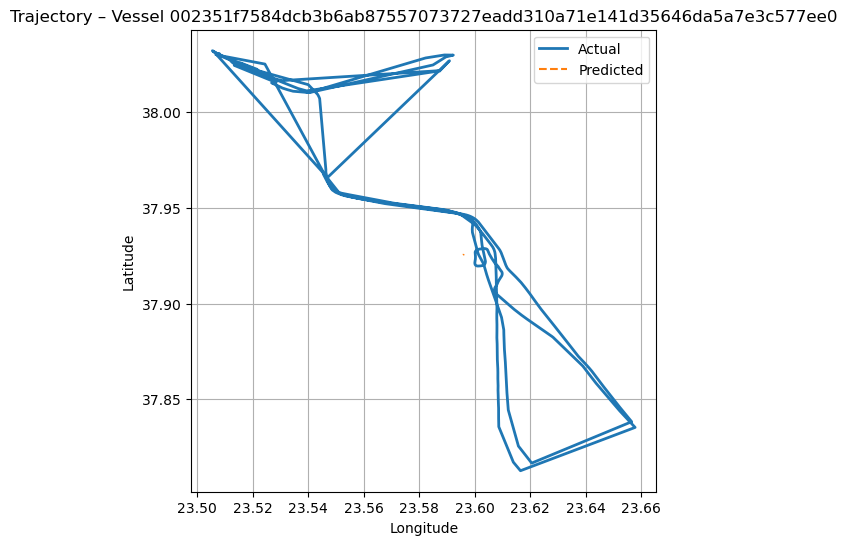

In [13]:
"""
AIS trajectory evaluation (Jan 2018)
- Load pretrained Chronos-2 models (lat, lon)
- Predict future trajectory
- Visualize actual vs predicted
"""

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame


def load_predictors(model_dir: Path):
    """
    Load pretrained Chronos-2 predictors.
    """
    lat = TimeSeriesPredictor.load(model_dir / "lat")
    lon = TimeSeriesPredictor.load(model_dir / "lon")
    return lat, lon


def load_jan_2018(csv_dir: Path) -> TimeSeriesDataFrame:
    """
    Load January 2018 AIS CSV files.
    """
    files = sorted(csv_dir.glob("*jan2018*.csv"))
    df = pd.concat(pd.read_csv(f) for f in files)

    df = df.sort_values(["vessel_id", "timestamp"])

    return TimeSeriesDataFrame.from_data_frame(
        df[["vessel_id", "timestamp", "lat", "lon"]],
        id_column="vessel_id",
        timestamp_column="timestamp",
    )


def predict(ts_df, lat_model, lon_model):
    """
    Predict latitude and longitude.
    """
    lat_pred = lat_model.predict(ts_df)["mean"]
    lon_pred = lon_model.predict(ts_df)["mean"]

    pred = lat_pred.to_frame("lat")
    pred["lon"] = lon_pred
    return pred


def plot_trajectory(actual: pd.DataFrame, predicted: pd.DataFrame, vessel_id: str):
    """
    Plot actual vs predicted trajectory.
    """
    plt.figure(figsize=(6, 6))
    plt.plot(actual["lon"], actual["lat"], label="Actual", linewidth=2)
    plt.plot(predicted["lon"], predicted["lat"], "--", label="Predicted")

    plt.title(f"Trajectory – Vessel {vessel_id}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.show()

traj= {"actual" : None,"predicted" : None}
def main():
    """
    End-to-end evaluation.
    """
    MODEL_DIR = Path("./chronos_models")
    CSV_2018 = Path("../dataset/piraeus/unipi_ais_dynamic_2018")

    lat_model, lon_model = load_predictors(MODEL_DIR)
    ts_2018 = load_jan_2018(CSV_2018)

    pred = predict(ts_2018, lat_model, lon_model)

    vessel_id = ts_2018.index.get_level_values(0)[0]
    traj["actual"] = ts_2018.loc[vessel_id][["lat", "lon"]]
    traj["predicted"] = pred.loc[vessel_id]

    plot_trajectory(traj["actual"], traj["predicted"], vessel_id)


if __name__ == "__main__":
    main()

In [ ]:
traj

In [17]:
"""
AIS trajectory evaluation (Jan 2018)
- Load pretrained Chronos-2 models
- Predict trajectory
- Visualize actual vs predicted in Folium (inline, no HTML saved)
"""

from pathlib import Path
import pandas as pd
import folium
from IPython.display import display
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame


def load_predictors(model_dir: Path):
    """
    Load pretrained Chronos-2 predictors.
    """
    return (
        TimeSeriesPredictor.load(model_dir / "lat"),
        TimeSeriesPredictor.load(model_dir / "lon"),
    )


def load_jan_2018(csv_dir: Path) -> TimeSeriesDataFrame:
    """
    Load January 2018 AIS data into TimeSeriesDataFrame.
    """
    files = sorted(csv_dir.glob("*jan2018*.csv"))
    df = pd.concat(pd.read_csv(f) for f in files)

    df = df.sort_values(["vessel_id", "timestamp"])

    return TimeSeriesDataFrame.from_data_frame(
        df[["vessel_id", "timestamp", "lat", "lon"]],
        id_column="vessel_id",
        timestamp_column="timestamp",
    )


def predict(ts_df, lat_model, lon_model) -> pd.DataFrame:
    """
    Predict latitude and longitude.
    """
    lat = lat_model.predict(ts_df)["mean"]
    lon = lon_model.predict(ts_df)["mean"]

    out = lat.to_frame("lat")
    out["lon"] = lon
    return out


def folium_trajectory(actual: pd.DataFrame, predicted: pd.DataFrame, vessel_id: str):
    """
    Render actual vs predicted trajectory using Folium.
    """
    center = [actual.iloc[0]["lat"], actual.iloc[0]["lon"]]

    m = folium.Map(location=center, zoom_start=11, tiles="CartoDB positron")

    folium.PolyLine(
        actual[["lat", "lon"]].values,
        color="blue",
        weight=4,
        tooltip="Actual",
    ).add_to(m)

    folium.PolyLine(
        predicted[["lat", "lon"]].values,
        color="red",
        weight=3,
        dash_array="5,5",
        tooltip="Predicted",
    ).add_to(m)

    folium.Marker(
        center,
        popup=f"Vessel {vessel_id}",
        icon=folium.Icon(color="green"),
    ).add_to(m)

    display(m)

t = {"actual" : None,"predicted" : None}
def main():
    """
    End-to-end evaluation.
    """
    MODEL_DIR = Path("./chronos_models")
    CSV_2018 = Path("../dataset/piraeus/unipi_ais_dynamic_2018")

    lat_model, lon_model = load_predictors(MODEL_DIR)
    ts_2018 = load_jan_2018(CSV_2018)

    pred = predict(ts_2018, lat_model, lon_model)

    vessel_id = ts_2018.index.get_level_values(0)[0]

    t["actual"] = ts_2018.loc[vessel_id][["lat", "lon"]]
    t["predicted"] = pred.loc[vessel_id]

    folium_trajectory(t["actual"], t["predicted"], vessel_id)


if __name__ == "__main__":
    main()


Loading predictor from path c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\chronos_models\lat
Loading predictor from path c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\chronos_models\lon
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best validation score: Chronos2
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best validation score: Chronos2


In [21]:
def rolling_predict(
    ts_df: TimeSeriesDataFrame,
    lat_model,
    lon_model,
    chunk_minutes: int = 10,
) -> pd.DataFrame:
    """
    Sliding-window prediction with periodic ground-truth reset.
    """
    preds = []
    step = chunk_minutes

    for start in range(0, len(ts_df) - step, step):
        hist = ts_df.iloc[: start + step]

        lat_p = lat_model.predict(hist)["mean"].iloc[-step:]
        lon_p = lon_model.predict(hist)["mean"].iloc[-step:]

        out = lat_p.to_frame("lat")
        out["lon"] = lon_p.values
        preds.append(out)

    return pd.concat(preds)

def main():
    """
    End-to-end evaluation.
    """
    MODEL_DIR = Path("./chronos_models")
    CSV_2018 = Path("../dataset/piraeus/unipi_ais_dynamic_2018")

    lat_model, lon_model = load_predictors(MODEL_DIR)
    ts_2018 = load_jan_2018(CSV_2018)

    vessel_id = ts_2018.index.get_level_values(0)[0]

    ts_vessel = ts_2018.loc[vessel_id].reset_index()
    ts_vessel["vessel_id"] = vessel_id

    ts_vessel_tsdf = TimeSeriesDataFrame.from_data_frame(
        ts_vessel,
        id_column="vessel_id",
        timestamp_column="timestamp",
    )

    pred = rolling_predict(
        ts_vessel_tsdf,
        lat_model,
        lon_model,
        chunk_minutes=10,
    )

    t["actual"] = ts_vessel[["lat", "lon"]].iloc[: len(pred)]
    t["predicted"] = pred

    folium_trajectory(t["actual"], t["predicted"], vessel_id)


main()

Loading predictor from path c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\chronos_models\lat
Loading predictor from path c:\Users\BBBS-AI-01\d\anomaly\piraeus_analysis\chronos_models\lon
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best validation score: Chronos2
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best validation score: Chronos2
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best validation score: Chronos2
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best validation score: Chronos2
data with frequency 'IRREG' has been resampled to frequency '10min'.
Model not specified in predict, will default to the model with the best

In [23]:
def folium_trajectory(actual: pd.DataFrame, predicted: pd.DataFrame, vessel_id: str):
    """
    Render actual vs predicted trajectory using Folium.
    """
    center = [actual.iloc[0]["lat"], actual.iloc[0]["lon"]]

    m = folium.Map(location=center, zoom_start=11, tiles="CartoDB positron")

    folium.PolyLine(
        actual[["lat", "lon"]].values,
        color="blue",
        weight=4,
        tooltip="Actual",
    ).add_to(m)

    folium.PolyLine(
        predicted[["lat", "lon"]].values,
        color="red",
        weight=3,
        dash_array="5,5",
        tooltip="Predicted",
    ).add_to(m)

    folium.Marker(
        center,
        popup=f"Vessel {vessel_id}",
        icon=folium.Icon(color="green"),
    ).add_to(m)

    display(m)

CSV_2018 = Path("../dataset/piraeus/unipi_ais_dynamic_2018")
ts_2018 = load_jan_2018(CSV_2018)

vessel_id = ts_2018.index.get_level_values(0)[0]
folium_trajectory(t["actual"], t["predicted"], vessel_id)

In [24]:
def folium_trajectory(actual: pd.DataFrame, predicted: pd.DataFrame, vessel_id: str):
    """
    Render actual vs predicted trajectory using Folium.
    """
    center = [actual.iloc[0]["lat"], actual.iloc[0]["lon"]]

    m = folium.Map(location=center, zoom_start=11, tiles="CartoDB positron")

    # Plot actual points
    for _, row in actual.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=3,
            color="blue",
            fill=True,
            fill_color="blue",
            tooltip="Actual",
        ).add_to(m)

    # Plot predicted points
    for _, row in predicted.iterrows():
        folium.CircleMarker(
            location=[row["lat"], row["lon"]],
            radius=3,
            color="red",
            fill=True,
            fill_color="red",
            tooltip="Predicted",
        ).add_to(m)


    folium.Marker(
        center,
        popup=f"Vessel {vessel_id}",
        icon=folium.Icon(color="green"),
    ).add_to(m)

    display(m)

CSV_2018 = Path("../dataset/piraeus/unipi_ais_dynamic_2018")
ts_2018 = load_jan_2018(CSV_2018)

vessel_id = ts_2018.index.get_level_values(0)[0]
folium_trajectory(t["actual"], t["predicted"], vessel_id)